In [15]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/gsatopo1/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator

import healpy as hp
from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/'

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

### Survey parameters
We generate lightcones with the following parameters

|Redshifts|$\Omega$ (deg$^2$)|$\theta_{\rm FWHM}$ (arcmin)|R|
|---|---|---|---|
|2.5-3.5|400|2|700|

In [2]:
def LC_params(line):
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=10*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=2,
                      spectral_supersample=4,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      Nmu=30,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [3]:
LC_CO=make_measurements(LC_params('CO'))

In [4]:
CO_map=np.asarray(LC_CO.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.2260928678521218
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [5]:
np.save('../../map_supersample_CO_T', CO_map)

In [5]:
LC_CII=make_measurements(LC_params('CII'))

In [6]:
CII_map=np.asarray(LC_CII.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.21690681990786664
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CII line left out filtering = 0.22609351109309683
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [8]:
np.save('../../map_supersample_CII_I', CII_map)

In [7]:
LC_Lya=make_measurements(LC_params('Lyalpha'))

In [8]:
Lya_map=np.asarray(LC_Lya.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078652
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of Lyalpha line left out filtering = 0.22609306652174377
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [10]:
LC_HI=make_measurements(LC_params('HI'))

In [11]:
HI_map=np.asarray(LC_HI.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of HI line left out filtering = 0.22609324449220436
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [11]:
np.save('../../map_supersample_Lya_I', Lya_map)

In [12]:
from nbodykit.source.mesh.catalog import CompensateCICShotnoise,get_compensation
from nbodykit.algorithms import FFTPower

kmin=0*u.Mpc**-1
kmax=2*u.Mpc**-1
dk=0.02*u.Mpc**-1

CO_compensation = get_compensation(interlaced=False,resampler=LC_CO.resampler)
COmap_to_use = LC_CO.obs_3d_map
COmap_to_use = (COmap_to_use.r2c().apply(CO_compensation[0][1], kind=CO_compensation[0][2])).c2r()

CII_compensation = get_compensation(interlaced=False,resampler=LC_CII.resampler)
CIImap_to_use = LC_CII.obs_3d_map
CIImap_to_use = (CIImap_to_use.r2c().apply(CII_compensation[0][1], kind=CII_compensation[0][2])).c2r()

Lya_compensation = get_compensation(interlaced=False,resampler=LC_Lya.resampler)
Lyamap_to_use = LC_Lya.obs_3d_map
Lyamap_to_use = (Lyamap_to_use.r2c().apply(Lya_compensation[0][1], kind=Lya_compensation[0][2])).c2r()

HI_compensation = get_compensation(interlaced=False,resampler=LC_HI.resampler)
HImap_to_use = LC_HI.obs_3d_map
HImap_to_use = (HImap_to_use.r2c().apply(HI_compensation[0][1], kind=HI_compensation[0][2])).c2r()

COxCO=FFTPower(COmap_to_use, '2d', Nmu=LC_CO.Nmu, poles=[0,2], los=[1,0,0], dk=dk.to(LC_CO.Mpch**-1).value, 
                 kmin=kmin.to(LC_CO.Mpch**-1).value, kmax=kmax.to(LC_CO.Mpch**-1).value,
                 BoxSize=np.array(LC_CO.Lbox.value, dtype=np.float32))

CIIxCII=FFTPower(CIImap_to_use, '2d', second=CIImap_to_use, Nmu=LC_CII.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CII.Mpch**-1).value, kmin=kmin.to(LC_CII.Mpch**-1).value, 
                kmax=kmax.to(LC_CII.Mpch**-1).value, BoxSize=np.array(LC_CII.Lbox.value, dtype=np.float32))

LyaxLya=FFTPower(Lyamap_to_use, '2d', Nmu=LC_Lya.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CO.Mpch**-1).value, kmin=kmin.to(LC_CO.Mpch**-1).value, 
                kmax=kmax.to(LC_CO.Mpch**-1).value, BoxSize=np.array(LC_Lya.Lbox.value, dtype=np.float32))

HIxHI=FFTPower(HImap_to_use, '2d', Nmu=LC_HI.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CO.Mpch**-1).value, kmin=kmin.to(LC_CO.Mpch**-1).value, 
                kmax=kmax.to(LC_CO.Mpch**-1).value, BoxSize=np.array(LC_HI.Lbox.value, dtype=np.float32))

COxCII=FFTPower(COmap_to_use, '2d', second=CIImap_to_use, Nmu=LC_CO.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CO.Mpch**-1).value, kmin=kmin.to(LC_CO.Mpch**-1).value, 
                kmax=kmax.to(LC_CO.Mpch**-1).value, BoxSize=np.array(LC_CO.Lbox.value, dtype=np.float32))

COxLya=FFTPower(COmap_to_use, '2d', second=Lyamap_to_use, Nmu=LC_CO.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CO.Mpch**-1).value, kmin=kmin.to(LC_CO.Mpch**-1).value, 
                kmax=kmax.to(LC_CO.Mpch**-1).value, BoxSize=np.array(LC_CO.Lbox.value, dtype=np.float32))

COxHI=FFTPower(COmap_to_use, '2d', second=HImap_to_use, Nmu=LC_CO.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CO.Mpch**-1).value, kmin=kmin.to(LC_CO.Mpch**-1).value, 
                kmax=kmax.to(LC_CO.Mpch**-1).value, BoxSize=np.array(LC_CO.Lbox.value, dtype=np.float32))

CIIxLya=FFTPower(CIImap_to_use, '2d', second=Lyamap_to_use, Nmu=LC_CII.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CII.Mpch**-1).value, kmin=kmin.to(LC_CII.Mpch**-1).value, 
                kmax=kmax.to(LC_CII.Mpch**-1).value, BoxSize=np.array(LC_CII.Lbox.value, dtype=np.float32))

CIIxHI=FFTPower(CIImap_to_use, '2d', second=HImap_to_use, Nmu=LC_CII.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CII.Mpch**-1).value, kmin=kmin.to(LC_CII.Mpch**-1).value, 
                kmax=kmax.to(LC_CII.Mpch**-1).value, BoxSize=np.array(LC_CII.Lbox.value, dtype=np.float32))

CIIxHI=FFTPower(CIImap_to_use, '2d', second=HImap_to_use, Nmu=LC_CII.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_CII.Mpch**-1).value, kmin=kmin.to(LC_CII.Mpch**-1).value, 
                kmax=kmax.to(LC_CII.Mpch**-1).value, BoxSize=np.array(LC_CII.Lbox.value, dtype=np.float32))

LyaxHI=FFTPower(Lyamap_to_use, '2d', second=HImap_to_use, Nmu=LC_Lya.Nmu, poles=[0,2], los=[1,0,0], 
                dk=dk.to(LC_Lya.Mpch**-1).value, kmin=kmin.to(LC_Lya.Mpch**-1).value, 
                kmax=kmax.to(LC_Lya.Mpch**-1).value, BoxSize=np.array(LC_Lya.Lbox.value, dtype=np.float32))


In [14]:
kCOxCO=(COxCO.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_COxCO = (COxCO.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit**2

kCIIxCII=(CIIxCII.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_CIIxCII = (CIIxCII.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CII.unit**2

kLyaxLya=(LyaxLya.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_LyaxLya = (LyaxLya.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_Lya.unit**2

kHIxHI=(HIxHI.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_HIxHI = (HIxHI.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_HI.unit**2

kCOxCII=(COxCII.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_COxCII = (COxCII.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit*LC_CII.unit

kCOxLya=(COxLya.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_COxLya = (COxLya.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit*LC_Lya.unit

kCOxHI=(COxHI.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_COxHI = (COxHI.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit*LC_HI.unit

kCIIxLya=(CIIxLya.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_CIIxLya = (CIIxLya.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CII.unit*LC_Lya.unit

kCIIxHI=(CIIxHI.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_CIIxHI = (CIIxHI.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CII.unit*LC_HI.unit

kLyaxHI=(LyaxHI.poles['k']*LC_Lya.Mpch**-1).to(u.Mpc**-1)
P0_LyaxHI = (LyaxHI.poles['power_0'].real*LC_Lya.Mpch**3).to(u.Mpc**3)*LC_Lya.unit*LC_HI.unit

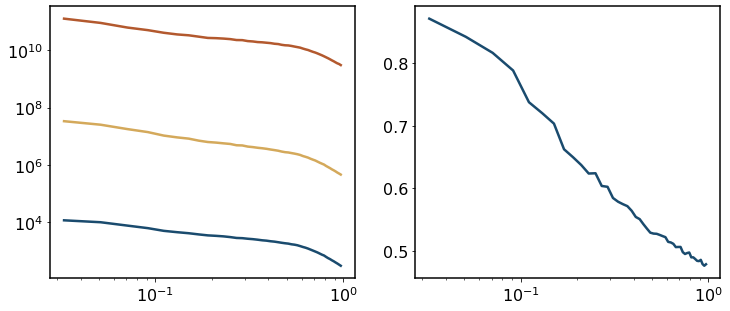

In [35]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(kCOxCO, P0_COxCO)
plt.loglog(kCOxCII, P0_COxCII)
plt.loglog(kCIIxCII, P0_CIIxCII)

plt.subplot(1,2,2)
plt.plot(kCOxCII, P0_COxCII/np.sqrt(P0_COxCO*P0_CIIxCII))
plt.xscale('log')

In [ ]:
cmap_cold=['#424c57','#538587','#85b692']

In [66]:
#dark_blue='#324356'
#turquoise='#54858a'
#yellow='#f0db92'
#yellow_orange='#edc080'
#orange='#C37854'

dark_blue='#424c57'
dark_red='#8f4a2c'
light_blue='#afb9bd'
light_red='#d4c2b0'
grey='#787878'

cmap_CO = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#32465c', light_blue])

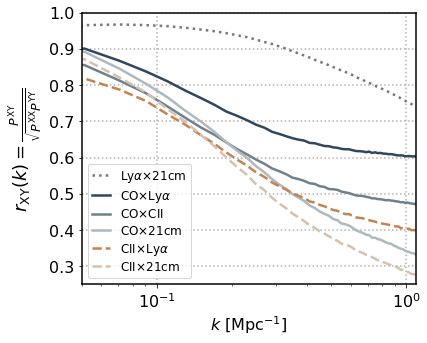

In [74]:
colors=cmap_CO(np.linspace(0,1,3))

fig=plt.figure(figsize=(6,5))

plt.plot(kLyaxHI, P0_LyaxHI/np.sqrt(P0_HIxHI*P0_LyaxLya), ':', label=r'Ly$\alpha$$\times$21cm', color=grey)
plt.plot(kCOxLya, P0_COxLya/np.sqrt(P0_COxCO*P0_LyaxLya), label=r'CO$\times$Ly$\alpha$', color=colors[0])
plt.plot(kCOxCII, P0_COxCII/np.sqrt(P0_COxCO*P0_CIIxCII), label=r'CO$\times$CII', color=colors[1])
plt.plot(kCOxHI, P0_COxHI/np.sqrt(P0_COxCO*P0_HIxHI), label=r'CO$\times$21cm', color=colors[2])
plt.plot(kCIIxLya, P0_CIIxLya/np.sqrt(P0_CIIxCII*P0_LyaxLya), '--', label=r'CII$\times$Ly$\alpha$', color="#c28453")
plt.plot(kCIIxHI, P0_CIIxHI/np.sqrt(P0_CIIxCII*P0_HIxHI), '--', label=r'CII$\times$21cm', color=light_red)
plt.legend(fontsize=12, labelspacing=0.3, columnspacing=0.2, handlelength=1.5)
plt.xlim(0.05, 1.1)
plt.ylim(0.25, 1)
plt.xlabel("$k$ [Mpc$^{-1}]$")
plt.ylabel(r'$r_{\rm XY}(k) = \frac{P^{\rm XY}}{\sqrt{P^{\rm XX}P^{\rm YY}}}$', fontsize=18)
plt.xscale('log')
plt.grid(linestyle='dotted', linewidth=1.5)
plt.savefig('../../corr_coef.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../../corr_coef.png', dpi=300, bbox_inches='tight')

In [ ]:
ekCOxCO=(COxCO.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_COxCO = (COxCO.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit**2

kCIIxCII=(CIIxCII.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_CIIxCII = (CIIxCII.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CII.unit**2

kLyaxLya=(LyaxLya.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_LyaxLya = (LyaxLya.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_Lya.unit**2

kCOxCII=(COxCII.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_COxCII = (COxCII.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit*LC_CII.unit

kCOxLya=(COxLya.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_COxLya = (COxLya.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit*LC_Lya.unit

kCIIxLya=(CIIxLya.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
P0_CIIxLya = (CIIxLya.poles['power_0'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CII.unit*LC_Lya.unit

In [18]:
COxCO.poles

<BinnedStatistic: dims: (k: 49), variables: ('k', 'power_0', 'power_2', 'modes')>

In [75]:
np.save('Pk_COxCO', [COxCO.poles['k'],COxCO.poles['power_0'].real, COxCO.poles['power_2'].real])
np.save('Pk_CIIxCII', [CIIxCII.poles['k'],CIIxCII.poles['power_0'].real, CIIxCII.poles['power_2'].real])
np.save('Pk_LyaxLya', [LyaxLya.poles['k'],LyaxLya.poles['power_0'].real, LyaxLya.poles['power_2'].real])
np.save('Pk_HIxHI', [HIxHI.poles['k'],HIxHI.poles['power_0'].real, HIxHI.poles['power_2'].real])
np.save('Pk_COxLya', [COxLya.poles['k'],COxLya.poles['power_0'].real, COxLya.poles['power_2'].real])
np.save('Pk_COxCII', [COxCII.poles['k'],COxCII.poles['power_0'].real, COxCII.poles['power_2'].real])
np.save('Pk_COxHI', [COxHI.poles['k'],COxHI.poles['power_0'].real, COxHI.poles['power_2'].real])
np.save('Pk_CIIxLya', [CIIxLya.poles['k'],CIIxLya.poles['power_0'].real, CIIxLya.poles['power_2'].real])
np.save('Pk_CIIxHI', [CIIxHI.poles['k'],CIIxHI.poles['power_0'].real, CIIxHI.poles['power_2'].real])
np.save('Pk_LyaxHI', [LyaxHI.poles['k'],LyaxHI.poles['power_0'].real, LyaxHI.poles['power_2'].real])

In [ ]:
np.save('Pk_CIIxHI', [CIIxHI.poles['k'],CIIxHI.poles['power_0'].real, CIIxHI.poles['power_2'].real])


## Cross-correlation with CMB maps

In [148]:
def LC_params(line):
    h=0.678
    zmin = 1;zmax = 2
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=0.5*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=2,
                      spectral_supersample=1,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      Nmu=30,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=1*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [149]:
LC_HI=make_measurements(LC_params('HI'))

In [150]:
HI_map=np.asarray(LC_HI.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.3693527603108968
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_91.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_92.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_93.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_94.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_95.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_96.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_97.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_98.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_99.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_100.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_101.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_102.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_103.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/

../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of HI line left out filtering = 0.3954986408317337
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


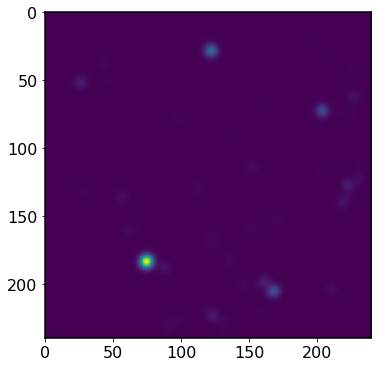

In [49]:
plt.imshow(HI_map[0])

In [2]:
def tp2ra(theta, phi):    
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def observed_mask_2d(nside, ra_min, ra_max, dec_min, dec_max):
    pix = np.arange(hp.nside2npix(nside), dtype=int)
    theta, phi = hp.pix2ang(nside, pix)
    ra, dec = tp2ra(theta, phi)

    DEC_mask=(dec>dec_min)&(dec<=dec_max)
    ra[ra>180]=ra[ra>180]-360
    RA_mask=(ra>ra_min)&(ra<=ra_max)

    mask=RA_mask&DEC_mask
    return mask

tSZmap=hp.fitsfunc.read_map('/home/gsatopo1/data-mkamion1/SkysimMaps/mdpl2_ltszNG_bahamas80_rot_sum_4_176_bnd_unb_1.0e+12_1.0e+18_v103021_lmax24000_nside8192_interp1.0_method1_1_lensed_map.fits')

/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 8192
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [8]:
pix_mask = np.logical_not(observed_mask_2d(8192, -0.5, 0.5, -0.5, 0.5))
tSZmap_masked=np.copy(tSZmap)
tSZmap_masked[pix_mask]=hp.UNSEEN

In [36]:
proj=hp.projector.CartesianProj(xsize=120, lonra =  [-0.5, 0.5], latra=[-0.5,0.5])

In [37]:
def func(x1, x2, x3):
    return hp.vec2pix(2**13, x1, x2, x3)

cartesian_tSZ=proj.projmap(tSZmap, func)

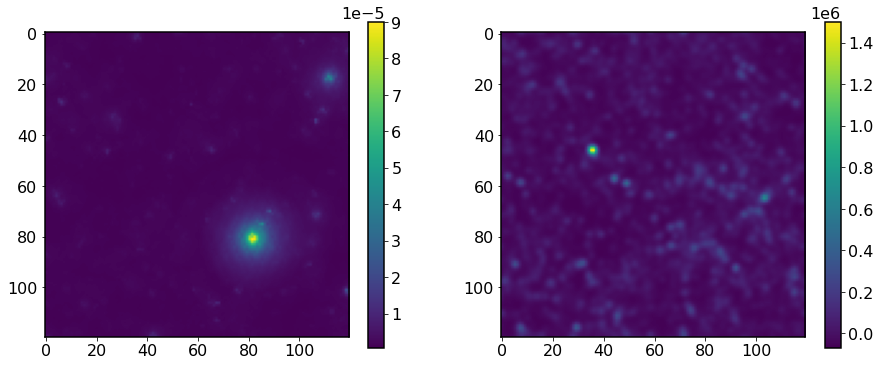

In [162]:
i=250
n=100

map_plot=np.sum(HI_map[i:(i+n)], axis=0)
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.imshow(cartesian_tSZ)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(map_plot)
plt.colorbar()


In [ ]:
o

In [157]:
HI_map.shape

(293, 120, 120)